In [1]:
import pandas as pd


ds_json = pd.read_json('data/lorawan_antwerp_2019_dataset.json')
gw_loc = pd.read_json('data/lorawan_antwerp_gateway_locations.json')

In [17]:
# Loading initial position coordinates form machine learning predictions
pos_pred_rssi = pd.read_csv('files/position_pred_RSSI.csv', index_col=0)
pos_pred_comb = pd.read_csv('files/position_pred_weather-comb.csv', index_col=0)

import pymap3d as pm 

ref_pos = {'lat0': 51.260644,
           'lon0': 4.370656,
           'h0': 0}

pos_pred_rssi['x'], pos_pred_rssi['y'], pos_pred_rssi['z'] = pm.geodetic2enu(lat=pos_pred_rssi['lat'], lon=pos_pred_rssi['lon'], h=0, **ref_pos)
pos_pred_rssi['x_i'], pos_pred_rssi['y_i'], pos_pred_rssi['z_i'] = pm.geodetic2enu(lat=pos_pred_rssi['pred_lat'], lon=pos_pred_rssi['pred_lon'], h=0, **ref_pos)

pos_pred_comb['x'], pos_pred_comb['y'], pos_pred_comb['z'] = pm.geodetic2enu(lat=pos_pred_comb['lat'], lon=pos_pred_comb['lon'], h=0, **ref_pos)
pos_pred_comb['x_i'], pos_pred_comb['y_i'], pos_pred_comb['z_i'] = pm.geodetic2enu(lat=pos_pred_comb['pred_lat'], lon=pos_pred_comb['pred_lon'], h=0, **ref_pos)


In [18]:
pos_pred_rssi.to_csv('files/pos_pred_rssi_enu.csv')
pos_pred_comb.to_csv('files/pos_pred_comb_enu.csv')

In [19]:
from leastsq_estimator import Least_square_estimator

estimator = Least_square_estimator()
est_rssi = estimator.estimate(data=pos_pred_rssi, 
                              reference_position=ref_pos, 
                              ds_json=ds_json, 
                              gateway_locations=gw_loc)

Receiving gateways: ['FF010595', 'FF01052A', 'FF010719']
Time of arrivals: ['2019-02-04T11:22:01.648575881+01:00', '2019-02-04T11:22:01.648584356+01:00', '2019-02-04T11:22:01.648593767+01:00']
Gateway coordinates (enu): 
[[ 2.59754574e+03 -4.16231476e+03 -1.88681445e+00]
 [ 5.52302324e+03 -2.09114343e+03 -2.72941239e+00]
 [-3.24157397e+03 -1.37584453e+03 -9.70539380e-01]]
Time difference of arrival: [[0, 1, -8.475000000000001e-06], [0, 2, -1.7886e-05], [1, 2, -9.411e-06]]
Optimized (x, y): ([2560.85412354  450.81885457], 2)


KeyError: "['2019-02-04T11:22:01.648575881+01:00', 51.2346038818359, 4.40909862518311, 51.23208923339844, 4.409801197052002, 2684.9511591465166, -2896.338965572992, -1.2219920228528736, 2734.1699610834303, -3176.074511503921, -1.3761017466401881] not in index"

In [65]:
gw_ids = []
toa = []
nonex_gw_ids =[] 
for i, _ in ds_json.iterrows():
    gw_meta = ds_json.loc[i, ['gateways']]
    for gws in gw_meta:
        for gw in gws:
            if gw['id'] in gw_loc:
                # Check wheather GW location information is actually availaable in the list or not
                gw_ids.append(gw['id'])
                toa.append(gw['rx_time']['time'])
            else:
                nonex_gw_ids.append(gw['id'])


In [10]:
gw_ids = []
toa = []
nonex_gw_ids =[] 
for i, _ in ds_json.sample(n=5).iterrows():
    gw_meta = ds_json.loc[i, ['gateways']]
    for gws in gw_meta:
        for gw in gws:
            gateway_id = gw['id']
            timestamp_type = gw['rx_time']['ts_type']
            if (gateway_id in gw_loc) & (timestamp_type == 'GPS_RADIO'):
                # Check wheather GW location information is actually availaable in the list or not
                gw_ids.append(gateway_id)
                toa.append(gw['rx_time']['time'])
            else:
                print(f'Gateway {gateway_id} location information is not available')


Gateway 080E00B9 location information is not available
Gateway 08060716 location information is not available
Gateway 080E00B9 location information is not available
Gateway 080E00B9 location information is not available


In [12]:
toa

['2019-01-21T11:59:14.91252356+01:00',
 '2019-01-21T11:59:14.91251849+01:00',
 '2019-01-08T14:42:56.42484721+01:00',
 '2019-01-08T14:42:56.42486388+01:00',
 '2019-01-20T06:48:07.962833159+01:00',
 '2019-02-02T12:50:05.544502528+01:00']

In [3]:
ds_json.sample(n=3).gateways

15071    [{'id': 'FF01085B', 'rssi': -111, 'snr': -11.0...
69106    [{'id': '080E00B9', 'rssi': -89, 'snr': 6.25, ...
91848    [{'id': 'FF0178DF', 'rssi': -104, 'snr': 10.0,...
Name: gateways, dtype: object

In [25]:
if 'FF01085B' in gw_loc:
    print('yes')

yes


In [66]:
pd.unique(nonex_gw_ids)

C:\Users\Sudip Barua\AppData\Local\Temp\ipykernel_12008\2497069903.py:1: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  pd.unique(nonex_gw_ids)


array(['004A05D4', '004A0DA4', 'C0000209', 'C000028C', '004A0D9C'],
      dtype=object)

In [67]:
from performance_eval import error_stats
import numpy as np

rssi = pd.read_csv('files/position_estimation_rssi.csv')

comb = pd.read_csv('files/position_estimation_comb.csv')



In [68]:
t = rssi[['lat', 'lon']].to_numpy()
p = rssi[['lat_est', 'lon_est']].to_numpy()
error_rssi = error_stats(t, p)


In [69]:
t = comb[['lat', 'lon']].to_numpy()
p = comb[['lat_est', 'lon_est']].to_numpy()
error_comb = error_stats(t, p)


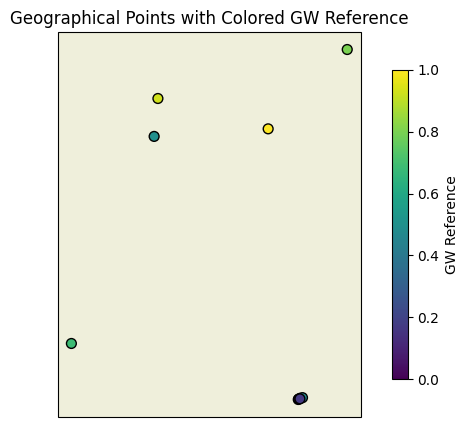

Map saved as colored_map.png


In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature


rssi = rssi.sample(n=10)
# Create a plot with Cartopy
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Add features to the map
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Plot the latitude and longitude points with colors based on the gw_ref column
# Use a colormap to convert the gw_ref values to colors
norm = plt.Normalize(rssi['gw_ref'].min(), rssi['gw_ref'].max())
cmap = plt.get_cmap('viridis')  # You can choose any colormap you prefer
colors = cmap(norm(rssi['gw_ref']))

# Plot points with the colormap
scatter = plt.scatter(rssi['lon'], rssi['lat'], color=colors, s=50, edgecolor='k', transform=ccrs.PlateCarree())

# Add a colorbar
cbar = plt.colorbar(scatter, ax=ax, orientation='vertical', fraction=0.02, pad=0.04)
cbar.set_label('GW Reference')

# Add title and labels
plt.title('Geographical Points with Colored GW Reference')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Save the plot to a file
output_file = 'colored_map.png'
plt.savefig(output_file, bbox_inches='tight')
plt.show()

print(f"Map saved as {output_file}")